In [1]:
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline 

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
from statsmodels.tsa.stattools import adfuller, kpss
import os
import sys
import json
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
#f= ["TS_cmems_reanalysis_temperature_from1987to2019_AdriaticSea.nc"]
#f_nc = [os.path.join(f) for f in f]
#f_ds = [ xr.open_dataset(nc) for nc in f_nc]
#print(f_ds)

In [4]:
f = xr.open_dataset("TSS_cmems_reanalysis_temperature_from1987to2019_AdriaticSea.nc")

In [5]:
f

<xarray.Dataset>
Dimensions:  (time: 12053, lat: 216, lon: 241)
Coordinates:
  * time     (time) datetime64[ns] 1987-01-01T12:00:00 ... 2019-12-31T12:00:00
    depth    float32 ...
  * lat      (lat) float32 37.02 37.06 37.1 37.15 ... 45.85 45.9 45.94 45.98
  * lon      (lon) float32 12.0 12.04 12.08 12.12 ... 21.88 21.92 21.96 22.0
Data variables:
    thetao   (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.8

In [6]:
#number of days in each month, size = len(time)
month_length = f.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 12053)>
array([31, 31, 31, ..., 31, 31, 31], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1987-01-01T12:00:00 ... 2019-12-31T12:00:00
    depth    float32 1.018

In [7]:
# the weights : grouping by sum ki = 'time.season'.
# 12 mesi in 4 gruppi
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# sum of the weights for each season is 1.0---normalizzare i pesi
#sum ci=1
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# weighted average and seasons definition 
#sum ci*ki
ds_weighted = (f * weights).groupby('time.season').sum(dim='time') 

In [8]:
#la media (c1k1+c2k2+...cnkn)/(c1+c2+...+cn) gruppi per ogni gruppo di stagione della temperatura
ds_unweighted = f.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

In [9]:
ds_unweighted 

<xarray.Dataset>
Dimensions:  (lat: 216, lon: 241, season: 4)
Coordinates:
    depth    float32 1.018
  * lat      (lat) float32 37.02 37.06 37.1 37.15 ... 45.85 45.9 45.94 45.98
  * lon      (lon) float32 12.0 12.04 12.08 12.12 ... 21.88 21.92 21.96 22.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    thetao   (season, lat, lon) float32 15.72 15.71 15.7 15.69 ... nan nan nan

In [10]:
ds_diff

<xarray.Dataset>
Dimensions:  (lat: 216, lon: 241, season: 4)
Coordinates:
    depth    float32 1.018
  * lat      (lat) float32 37.02 37.06 37.1 37.15 ... 45.85 45.9 45.94 45.98
  * lon      (lon) float32 12.0 12.04 12.08 12.12 ... 21.88 21.92 21.96 22.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    thetao   (season, lat, lon) float64 0.0297 0.02961 0.02949 ... nan nan nan

Text(0.5, 0.98, 'Seasonal Temperature at Sea Surface')

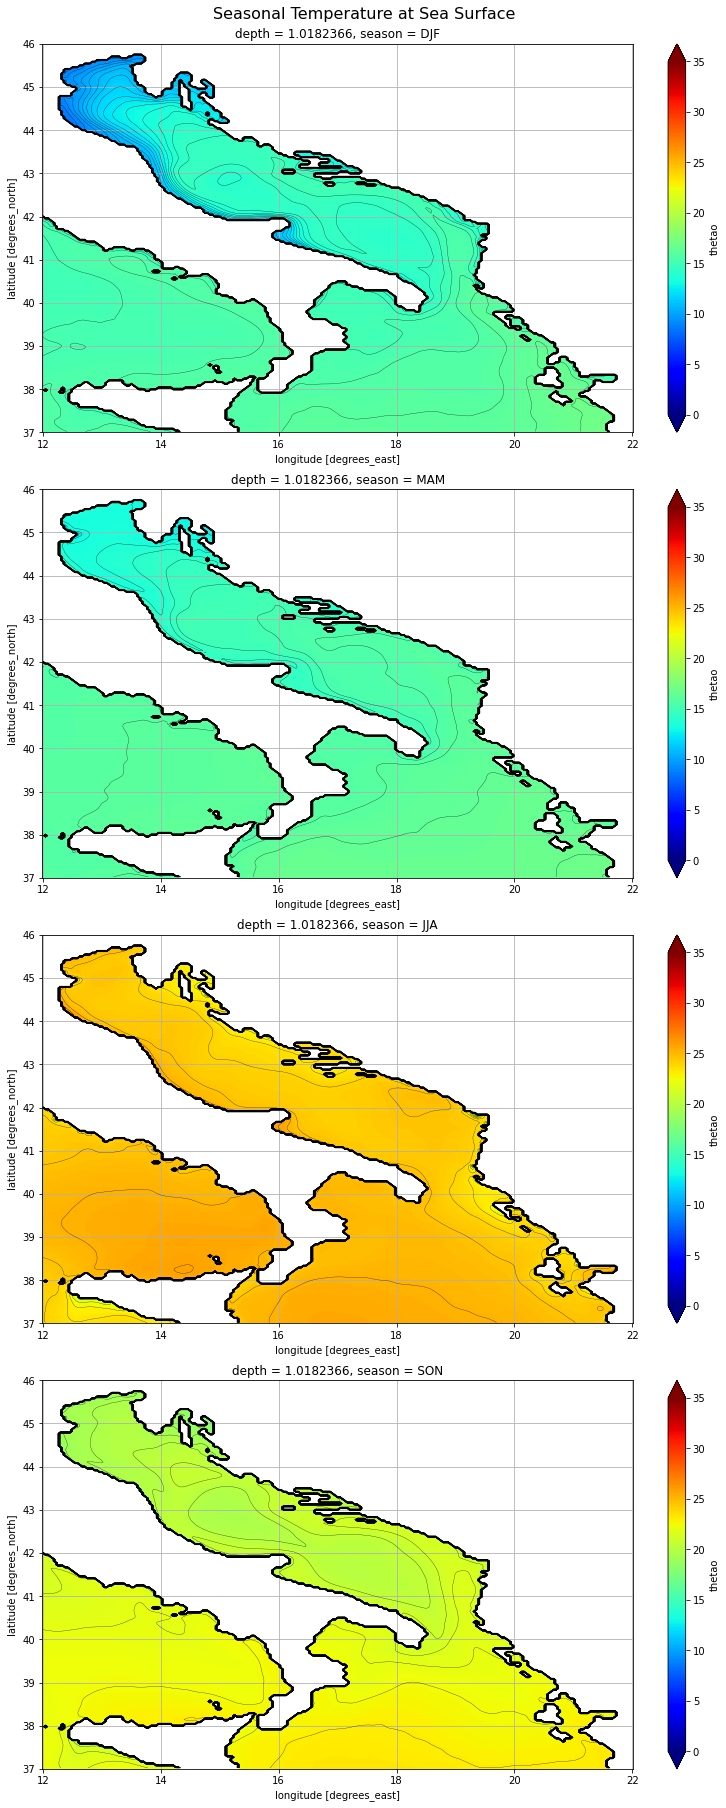

In [11]:
notnull = pd.notnull(ds_unweighted['thetao'][0])
################################################################
width_inch = 10
height_inch = 25


fig,axes = plt.subplots(4,1,figsize=(width_inch, height_inch),constrained_layout=True)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['thetao'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=0, vmax=35,shading='flat', cmap=plt.cm.jet,
        extend='both')
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    lines=ds_weighted['thetao'].sel(season=season).plot.contour(ax=axes[i],alpha=0.9,linewidths=0.3,colors = 'k',linestyles='None',levels=50)

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()

fig.suptitle('Seasonal Temperature at Sea Surface', fontsize=16)